In [ ]:
# Install Roboflow and Detectron2
!pip install roboflow
!pip install pyyaml==5.1  # Specific version for compatibility
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git 

In [ ]:
from roboflow import Roboflow
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances


In [ ]:
# Initialize Roboflow
rf = Roboflow(api_key="aj1YNkFeRPD8FAf7DMpN")

# Access the specific project and version
project = rf.workspace("opticaldisk").project("opticaldisk")
version = project.version(2)

# Download the dataset in COCO format
dataset = version.download("coco")

# Print the dataset location
print(dataset.location)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Opticaldisk-2 in coco:: 100%|██████████| 878/878 [00:00<00:00, 7253.82it/s]

/content/Opticaldisk-2


In [ ]:
# Paths to the dataset
train_json = os.path.join(dataset.location, "train/_annotations.coco.json")
train_images = os.path.join(dataset.location, "train")
val_json = os.path.join(dataset.location, "valid/_annotations.coco.json")
val_images = os.path.join(dataset.location, "valid")

# Register the dataset with Detectron2
register_coco_instances("opticaldisk_train", {}, train_json, train_images)
register_coco_instances("opticaldisk_val", {}, val_json, val_images)

# Verify the registration by printing the number of training images
dataset_dicts = DatasetCatalog.get("opticaldisk_train")
metadata = MetadataCatalog.get("opticaldisk_train")
print(f"Number of training images: {len(dataset_dicts)}")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Number of training images: 736


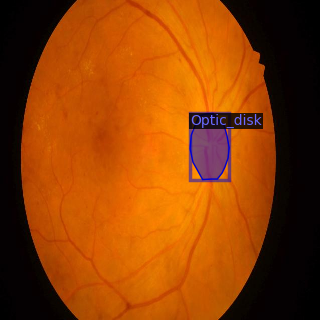

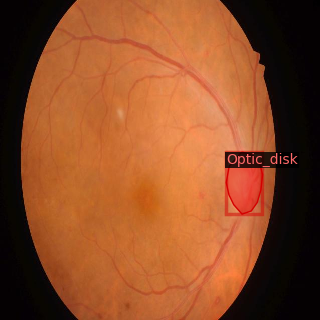

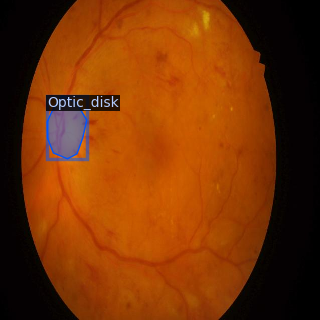

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# Visualize a few samples from the training set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("opticaldisk_train",)
cfg.DATASETS.TEST = ("opticaldisk_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained model
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 1000    # Number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Get the number of classes from the metadata
metadata = MetadataCatalog.get("opticaldisk_train")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.thing_classes)  # Number of classes in the dataset

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/18 07:23:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 197MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/18 07:23:36 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


[09/18 07:23:46 d2.utils.events]:  eta: 0:04:34  iter: 19  total_loss: 1.329  loss_cls: 0.8761  loss_box_reg: 0.4257  loss_rpn_cls: 0.03334  loss_rpn_loc: 0.004956    time: 0.2816  last_time: 0.3113  data_time: 0.0174  last_data_time: 0.0049   lr: 4.9953e-06  max_mem: 1737M
[09/18 07:23:55 d2.utils.events]:  eta: 0:04:31  iter: 39  total_loss: 1.188  loss_cls: 0.7688  loss_box_reg: 0.3497  loss_rpn_cls: 0.03614  loss_rpn_loc: 0.006302    time: 0.2864  last_time: 0.2861  data_time: 0.0117  last_data_time: 0.0049   lr: 9.9902e-06  max_mem: 1739M
[09/18 07:24:01 d2.utils.events]:  eta: 0:04:20  iter: 59  total_loss: 1.066  loss_cls: 0.6026  loss_box_reg: 0.413  loss_rpn_cls: 0.02466  loss_rpn_loc: 0.004367    time: 0.2803  last_time: 0.3081  data_time: 0.0079  last_data_time: 0.0106   lr: 1.4985e-05  max_mem: 1739M
[09/18 07:24:07 d2.utils.events]:  eta: 0:04:21  iter: 79  total_loss: 1.102  loss_cls: 0.5108  loss_box_reg: 0.5573  loss_rpn_cls: 0.01506  loss_rpn_loc: 0.003644    time: 0.2

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("opticaldisk_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "opticaldisk_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [09/18 07:28:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/18 07:28:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/18 07:28:43 d2.data.datasets.coco]: Loaded 90 images in COCO format from /content/Opticaldisk-2/valid/_annotations.coco.json
[09/18 07:28:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/18 07:28:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/18 07:28:43 d2.data.common]: Serializing 90 elements to byte tensors and concatenating them all ...
[09/18 07:28:43 d2.data.common]: Serialized dataset takes 0.05 MiB
[09/18 07:28:43 d2.evaluation.evaluator]: Start inference on 90 batches


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/18 07:28:44 d2.evaluation.evaluator]: Inference done 11/90. Dataloading: 0.0015 s/iter. Inference: 0.0789 s/iter. Eval: 0.0002 s/iter. Total: 0.0806 s/iter. ETA=0:00:06
[09/18 07:28:49 d2.evaluation.evaluator]: Inference done 73/90. Dataloading: 0.0018 s/iter. Inference: 0.0787 s/iter. Eval: 0.0002 s/iter. Total: 0.0809 s/iter. ETA=0:00:01
[09/18 07:28:51 d2.evaluation.evaluator]: Total inference time: 0:00:06.918841 (0.081398 s / iter per device, on 1 devices)
[09/18 07:28:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.078689 s / iter per device, on 1 devices)
[09/18 07:28:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/18 07:28:51 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/18 07:28:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/18 07:28:51 d2.evaluation.f

OrderedDict([('bbox',
              {'AP': 79.36568127845072,
               'AP50': 97.96479647964797,
               'AP75': 97.96479647964797,
               'APs': nan,
               'APm': 77.75202155147484,
               'APl': 82.52664481706144,
               'AP-Diabetic': nan,
               'AP-Optic_disk': 79.36568127845072})])

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
import random
import cv2


[09/18 07:30:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [09/18 07:30:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/18 07:30:03 d2.data.datasets.coco]: Loaded 90 images in COCO format from /content/Opticaldisk-2/valid/_annotations.coco.json


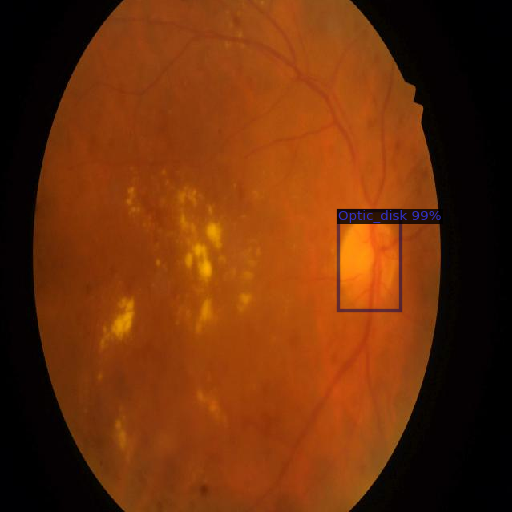

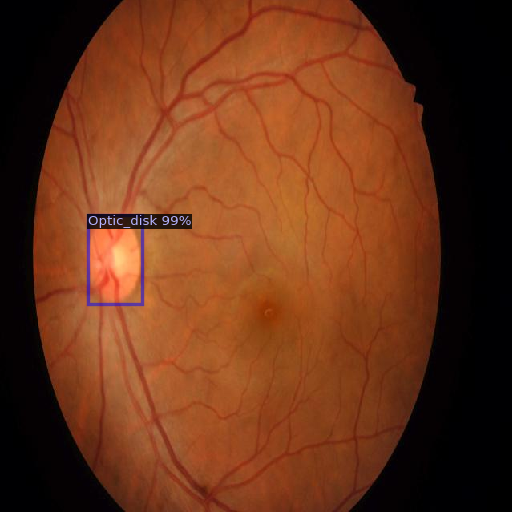

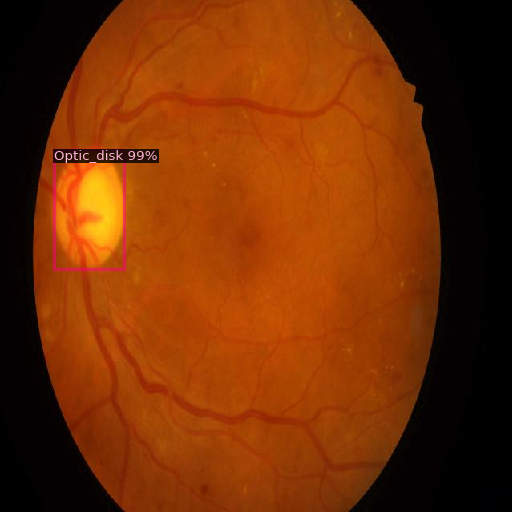

In [ ]:
# Set the model weights to the final trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Visualize some predictions
dataset_dicts = DatasetCatalog.get("opticaldisk_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate the model on the validation set
evaluator = COCOEvaluator("opticaldisk_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "opticaldisk_val")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

# Print metrics to see the results
print(metrics)


WARNING [09/18 07:30:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/18 07:30:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/18 07:30:24 d2.data.datasets.coco]: Loaded 90 images in COCO format from /content/Opticaldisk-2/valid/_annotations.coco.json
[09/18 07:30:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/18 07:30:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/18 07:30:24 d2.data.common]: Serializing 90 elements to byte tensors and concatenating them all ...
[09/18 07:30:24 d2.data.common]: Serialized dataset takes 0.05 MiB
[09/18 07:30:24 d2.evaluation.evaluator]: Start inference on 90 batches


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/18 07:30:25 d2.evaluation.evaluator]: Inference done 11/90. Dataloading: 0.0013 s/iter. Inference: 0.0767 s/iter. Eval: 0.0002 s/iter. Total: 0.0782 s/iter. ETA=0:00:06
[09/18 07:30:30 d2.evaluation.evaluator]: Inference done 70/90. Dataloading: 0.0060 s/iter. Inference: 0.0778 s/iter. Eval: 0.0003 s/iter. Total: 0.0842 s/iter. ETA=0:00:01
[09/18 07:30:32 d2.evaluation.evaluator]: Total inference time: 0:00:07.253759 (0.085338 s / iter per device, on 1 devices)
[09/18 07:30:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.078032 s / iter per device, on 1 devices)
[09/18 07:30:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/18 07:30:32 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/18 07:30:32 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/18 07:30:32 d2.evaluation.f